# Perform Random Forest Regressor on caluclated SOH1 using IBS signals + charging cycle parameters

In [36]:
import pandas as pd
import os, sys
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path
from datetime import datetime, timezone
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

CYCLE_METRICS_CSV_DIR = Path("outputs/logs") # resolve path


In [37]:
# Read in generated charge cycle metrics data

path = CYCLE_METRICS_CSV_DIR / "cycle_metrics_all.csv"
df = pd.read_csv(path)

print(df.shape)
df.head()

(75, 119)


,cycle_start,cycle_end,source_file,cycle_id,cycle_idx,duration_s,V_peak_charge,V_mean_charge,V_tail_mean,time_absorption_s,...,IBS_Sulfation__last,IBS_BatteryDefect__mean,IBS_BatteryDefect__median,IBS_BatteryDefect__std,IBS_BatteryDefect__min,IBS_BatteryDefect__max,IBS_BatteryDefect__p10,IBS_BatteryDefect__p90,IBS_BatteryDefect__first,IBS_BatteryDefect__last
0,2025-06-26 02:20:47+00:00,2025-06-26 02:40:03+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,0,1156.0,14.115,14.106860,14.100594,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-06-26 11:24:45+00:00,2025-06-26 12:02:32+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,1,2267.0,14.114,14.102164,14.099900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-06-26 13:09:11+00:00,2025-06-26 13:19:50+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,2,639.0,14.114,14.104331,14.100833,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-06-26 17:47:23+00:00,2025-06-26 18:22:49+00:00,12V_Management_2025-06-26_13-39-25_IBS_only.csv,12V_Management_2025-06-26_13-39-25_IBS_only.csv#0,0,2126.0,14.113,14.096117,14.101900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-06-26 22:55:27+00:00,2025-06-26 22:55:42+00:00,12V_Management_2025-06-26_13-39-25_IBS_only.csv,12V_Management_2025-06-26_13-39-25_IBS_only.csv#1,1,15.0,14.062,14.044375,14.044375,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
y = df["target_soh1"]
X = df.drop(["cycle_start", "cycle_end", "source_file", "cycle_id", "target_soh1"], axis=1)
print(X.shape, y.shape)

(75, 114) (75,)


In [39]:
# Split data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Create Random Forest Ensemble pipeline cross validation using hyperparamters

rf_pipe = Pipeline([
    ("rf", RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        oob_score=False,          # set True if you want OOB (requires bootstrap=True)
        bootstrap=True
    ))
])

rf_param_grid = {
    "rf__n_estimators": [200, 400, 800],
    "rf__max_depth": [None, 8, 12, 16],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    # default for regressor is 1.0 (all features); try smaller subsets too:
    "rf__max_features": ["sqrt", 0.5, 1.0]
}

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    cv=5,                 # see GroupKFold variant below if you have source_file groups
    scoring="r2",
    n_jobs=-1,
    return_train_score=True
)

rf_grid.fit(X_train, y_train)
print("Best params:", rf_grid.best_params_)
print("CV best R²:", rf_grid.best_score_)
print("Test R²   :", rf_grid.best_estimator_.score(X_test, y_test))


Best params: {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 800}
CV best R²: 0.7561862369886703
Test R²   : 0.6933710873692115


In [41]:
best_rf = rf_grid.best_estimator_.named_steps["rf"]

feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print(feature_importances.head(10))


                        feature  importance
82     IBS_DischargeableAh__max    0.077131
86    IBS_DischargeableAh__last    0.067296
84     IBS_DischargeableAh__p90    0.053590
9                   soc_end_pct    0.042557
79  IBS_DischargeableAh__median    0.039912
48       IBS_StateOfCharge__p90    0.039243
78    IBS_DischargeableAh__mean    0.038851
46       IBS_StateOfCharge__max    0.038331
50      IBS_StateOfCharge__last    0.033785
43    IBS_StateOfCharge__median    0.025938


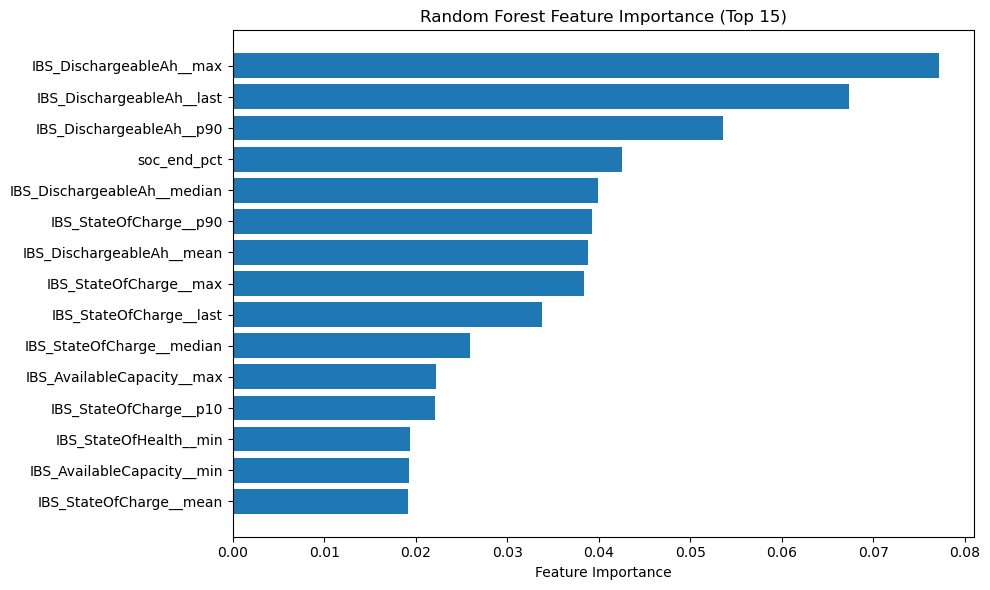

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["feature"][:15][::-1],
         feature_importances["importance"][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


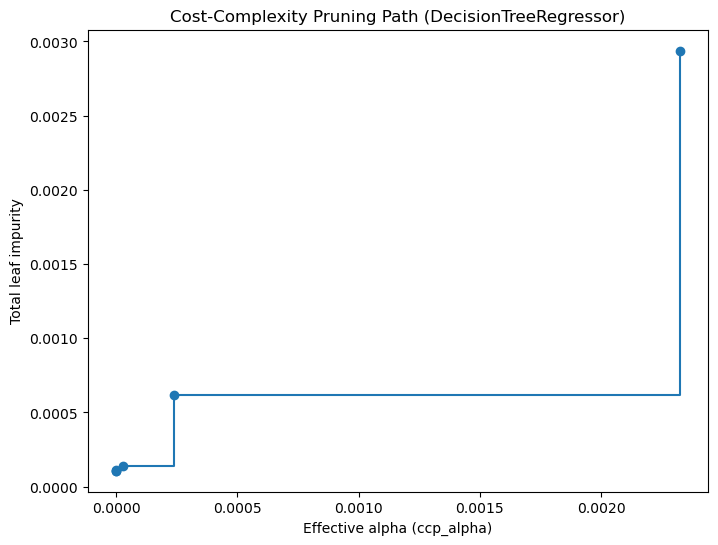

In [43]:
# Get pruning path for your training data
path = best_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(8,6))
plt.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
plt.xlabel("Effective alpha (ccp_alpha)")
plt.ylabel("Total leaf impurity")
plt.title("Cost-Complexity Pruning Path (DecisionTreeRegressor)")
plt.show()

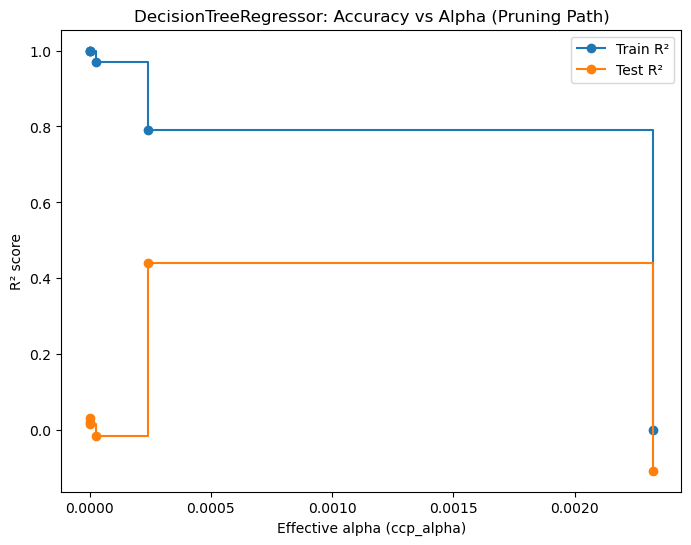

In [44]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Compute pruning path
path = best_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

train_scores, test_scores = [], []

# Loop over alphas and fit/prune trees
for alpha in ccp_alphas:
    dt = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    dt.fit(X_train, y_train)
    
    train_scores.append(r2_score(y_train, dt.predict(X_train)))
    test_scores.append(r2_score(y_test, dt.predict(X_test)))

# Plot train vs test R² across alphas
plt.figure(figsize=(8,6))
plt.plot(ccp_alphas, train_scores, marker="o", label="Train R²", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker="o", label="Test R²", drawstyle="steps-post")
plt.xlabel("Effective alpha (ccp_alpha)")
plt.ylabel("R² score")
plt.title("DecisionTreeRegressor: Accuracy vs Alpha (Pruning Path)")
plt.legend()
plt.show()


                          feature  importance_mean  importance_std
82       IBS_DischargeableAh__max         1.613213        0.392296
78      IBS_DischargeableAh__mean         0.078820        0.059456
40  IBS_BatteryTemperature__first         0.023797        0.019337
0                       cycle_idx         0.000000        0.000000
85     IBS_DischargeableAh__first         0.000000        0.000000
83       IBS_DischargeableAh__p10         0.000000        0.000000
81       IBS_DischargeableAh__min         0.000000        0.000000
80       IBS_DischargeableAh__std         0.000000        0.000000
79    IBS_DischargeableAh__median         0.000000        0.000000
77    IBS_AvailableCapacity__last         0.000000        0.000000
76   IBS_AvailableCapacity__first         0.000000        0.000000
75     IBS_AvailableCapacity__p90         0.000000        0.000000
74     IBS_AvailableCapacity__p10         0.000000        0.000000
73     IBS_AvailableCapacity__max         0.000000        0.00

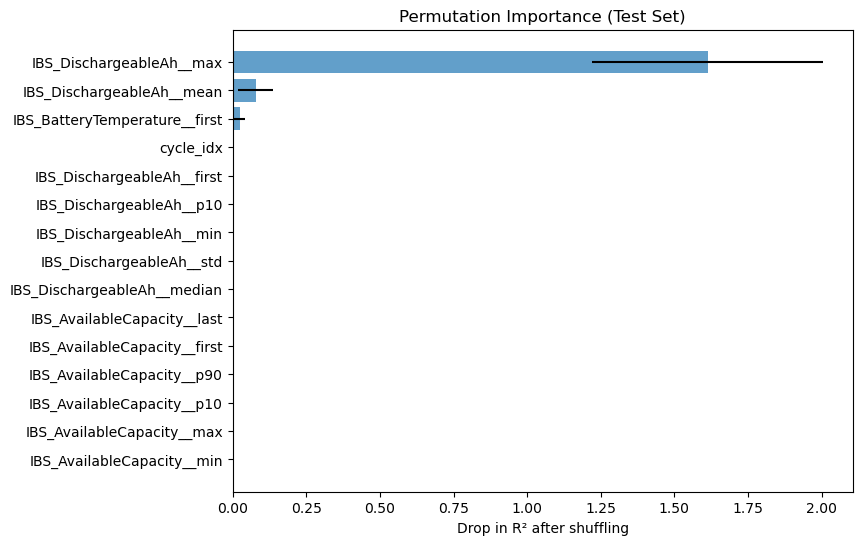

In [45]:
from sklearn.inspection import permutation_importance

# Run permutation importance on the test set
perm = permutation_importance(
    grid.best_estimator_, 
    X_test, y_test,
    n_repeats=10,            # repeat shuffling for stability
    random_state=42,
    n_jobs=-1
)

# Put results into a sorted DataFrame
perm_importances = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

# Show top 15
print(perm_importances.head(15))

# Plot
plt.figure(figsize=(8,6))
plt.barh(
    perm_importances["feature"].head(15)[::-1],
    perm_importances["importance_mean"].head(15)[::-1],
    xerr=perm_importances["importance_std"].head(15)[::-1],
    alpha=0.7
)
plt.xlabel("Drop in R² after shuffling")
plt.title("Permutation Importance (Test Set)")
plt.show()
